# Backtesting

Using 2 strategies

- self defined strategy
- buy and hold

## Self Strategy

Initial cash = $100000

Every buy/sell order = 100 stocks

## Buy and Hold

Buy on first day and hold till last.

## Value-at-risk

The maximum loss we can incur using self defined stratefy with `99%` confidence. VAR is calculted using the variance-covariance method.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
my_year_month_fmt = mdates.DateFormatter('%m/%y')
from scipy.stats import norm

In [2]:
data = pd.read_csv("formatted_aapl_stock_data_sentiment.csv")
data[['date']] = data[['date']].apply(pd.to_datetime)

In [3]:
def var_cov_var(P, c, mu, sigma):
    """
    Variance-Covariance calculation of daily Value-at-Risk
    using confidence level c, with mean of returns mu
    and standard deviation of returns sigma, on a portfolio
    of value P.
    """
    alpha = norm.ppf(1-c, mu, sigma)
    return P - P*(alpha + 1)

In [4]:
def backtest(data):
    cash = 100000
    position = 0
    total = 0
     
    data['Total'] = 100000
    data['BuyHold'] = 100000
    # To compute the Buy and Hold value, invest all cash in the Adj Close on the first day of the backtest
    positionBeginning = int(100000/float(data.iloc[0]['Adj Close']))
    increment = 100
    rets = []
     
    for row in data.iterrows():
        price = float(row[1]['Adj Close'])
        signal = float(row[1]['trading_positions'])
        rets.append(cash)
        if(signal > 0 and cash - increment * price > 0):
            # Buy only if signal is buy and enough funds to buy
            cash = cash - increment * price
            position = position + increment
            print(row[1]['date'].strftime('%d %b %Y')+" Position = "+str(position)+" Cash = "+str(cash)+" // Total = {:,}".format(int(position*price+cash)))
             
        elif(signal < 0 and abs(position*price) < cash and position > 0):
            # Sell only if signal is sell and you are at a loss position
            cash = cash + increment * price
            position = position - increment
            print(row[1]['date'].strftime('%d %b %Y')+" Position = "+str(position)+" Cash = "+str(cash)+" // Total = {:,}".format(int(position*price+cash)))
             
        data.loc[data.date == row[1]['date'], 'Total'] = float(position*price+cash)
        data.loc[data.date == row[1]['date'], 'BuyHold'] = price*positionBeginning
         
    return position*price+cash, rets

In [5]:
# Backtest
backtestResult, rets = backtest(data)
print(("Backtest => {:,} USD").format(backtestResult))
perf = (float(backtestResult)/100000-1)*100
daysDiff = (data.tail(1).date-data.head(1).date[0]).iloc[0].days
print(daysDiff)
perf = (perf/(daysDiff))*360
print("Annual return => "+str(perf)+"%")
print()

data['rets'] = rets
data['rets_percent_change'] = data['rets'].pct_change()
P = 100000   # 100,000 USD
c = 0.99  # 99% confidence interval
mu = np.mean(data["rets_percent_change"])
sigma = np.std(data["rets_percent_change"])

var = var_cov_var(P, c, mu, sigma)
print(("Value-at-Risk => {:,} USD").format(var))
print()
 
# Buy and Hold
perfBuyAndHold = float(data.tail(1)['Close'])/float(data.head(1)['Adj Close'])-1
print(("Buy and Hold => {:,} USD").format(int((1+perfBuyAndHold)*100000)))
perfBuyAndHold = (perfBuyAndHold/(daysDiff))*360
print("Annual return => "+str(perfBuyAndHold*100)+"%")
print()

31 Dec 1999 Position = 100 Cash = 99754.1081 // Total = 100,000
23 Oct 2007 Position = 0 Cash = 101535.0287 // Total = 101,535
12 Nov 2007 Position = 100 Cash = 100064.0667 // Total = 101,535
23 Jan 2008 Position = 200 Cash = 98733.6378 // Total = 101,394
24 Jan 2008 Position = 300 Cash = 97436.4051 // Total = 101,328
25 Jan 2008 Position = 400 Cash = 96192.65000000001 // Total = 101,167
28 Jan 2008 Position = 500 Cash = 94948.89490000001 // Total = 101,167
29 Jan 2008 Position = 600 Cash = 93690.50290000002 // Total = 101,240
30 Jan 2008 Position = 700 Cash = 92425.98830000003 // Total = 101,277
06 Feb 2008 Position = 800 Cash = 91258.86190000003 // Total = 100,595
07 Feb 2008 Position = 900 Cash = 90099.00570000004 // Total = 100,537
17 Sep 2008 Position = 1000 Cash = 88876.10560000004 // Total = 101,105
23 Sep 2008 Position = 1100 Cash = 87662.67630000004 // Total = 101,010
29 Sep 2008 Position = 1200 Cash = 86655.69480000004 // Total = 98,739
30 Sep 2008 Position = 1300 Cash = 8556

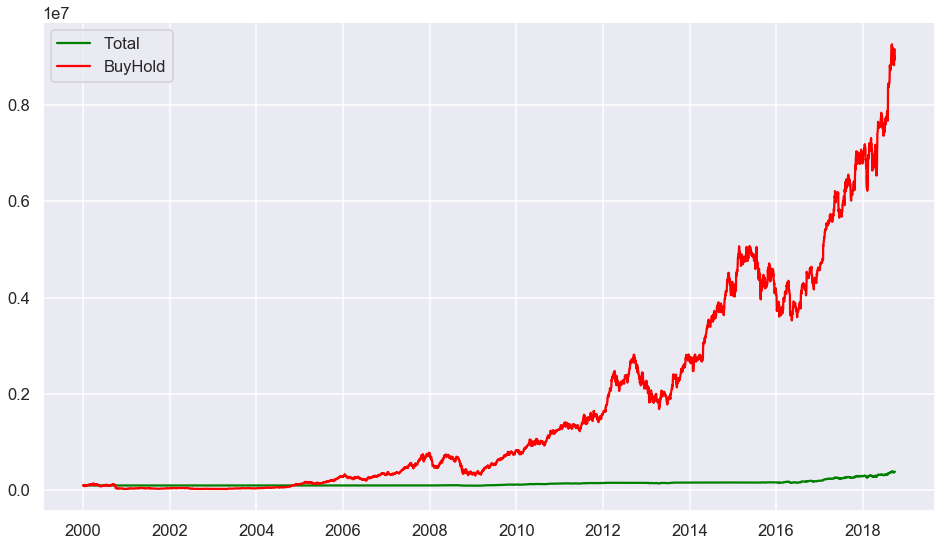

In [6]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(data.date, data['Total'], label='Total', color='g')
ax.plot(data.date, data['BuyHold'], label='BuyHold', color='r')
ax.legend(loc=0)